#Import libraries

In [ ]:
!pip install pandas torch transformers datasets scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 121.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 158.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 116.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0


In [ ]:
import torch

#Set device

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')  # CUDA GPU
elif torch.backends.mps.is_available():
    device = torch.device('mps') #Apple GPU
else:
    device = torch.device("cpu")

In [ ]:
print('Using device:', device)
#Additional Info when using cuda
if device.type == 'cuda':
    print("Device name: ", torch.cuda.get_device_name(0))
    print("Device properties:", torch.cuda.get_device_properties(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
Device name:  Tesla T4
Device properties: _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


#Load dataset

In [ ]:
import pandas as pd
from datasets import load_dataset
import numpy as np

In [ ]:
review_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023","raw_review_All_Beauty")

# User Reviews dataframe (reviews are in the 'full' split for this dataset)
reviews_df = pd.DataFrame(review_dataset['full'])

README.md:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

All_Beauty.jsonl:   0%|          | 0.00/327M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

In [ ]:
# Map user_id and parent_asin to indices
user_map = {user: idx for idx, user in enumerate(reviews_df["user_id"].unique())}
item_map = {asin: idx for idx, asin in enumerate(reviews_df["parent_asin"].unique())}


In [ ]:
meta_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023","raw_meta_All_Beauty")

# User Reviews dataframe (reviews are in the 'full' split for this dataset)
meta_df = pd.DataFrame(meta_dataset['full'])

meta_All_Beauty.jsonl:   0%|          | 0.00/213M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

#Split data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
reviews_df["user_idx"] = reviews_df["user_id"].map(user_map)
reviews_df["item_idx"] = reviews_df["parent_asin"].map(item_map)

# Train-test split
train, test = train_test_split(reviews_df, test_size=0.2, random_state=42)

#NCF model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32, hidden_dims=[64, 32], dropout_rate=0.5):
        super(NCF, self).__init__()
        # Embedding layers
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        # Neural layers
        input_dim = embedding_dim * 2
        layers = []
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        self.mlp = nn.Sequential(*layers)

        # Final prediction layer
        self.output = nn.Linear(hidden_dims[-1], 1)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, user_idx, item_idx):
        # Embeddings
        user_emb = self.user_embedding(user_idx)
        item_emb = self.item_embedding(item_idx)

        # Concatenate and pass through MLP
        x = torch.cat([user_emb, item_emb], dim=-1)
        x = self.mlp(x)

        x = self.dropout(x)

        # Prediction
        return torch.sigmoid(self.output(x))


#prepare dataloader

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ReviewsDataset(Dataset):
    def __init__(self, data):
        self.user_idx = data["user_idx"].values
        self.item_idx = data["item_idx"].values
        self.rating = data["rating"].values

    def __len__(self):
        return len(self.rating)

    def __getitem__(self, idx):
        return {
            "user_idx": torch.tensor(self.user_idx[idx], dtype=torch.long),
            "item_idx": torch.tensor(self.item_idx[idx], dtype=torch.long),
            "rating": torch.tensor(self.rating[idx], dtype=torch.float),
        }

#  DataLoaders
train_dataset = ReviewsDataset(train)
test_dataset = ReviewsDataset(test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


#train

In [ ]:
results = {"train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []
    }

In [ ]:
def train_model(model, train_loader, test_loader, epochs=10, lr=0.001):
    model.to("cuda")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_mae = 0
        for batch in train_loader:
            user_idx = batch["user_idx"].to("cuda")
            item_idx = batch["item_idx"].to("cuda")
            ratings = batch["rating"].to("cuda")

            optimizer.zero_grad()
            predictions = model(user_idx, item_idx).squeeze()
            loss = criterion(predictions, ratings / 5.0)  # Normalize ratings
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_mae += torch.abs(predictions - (ratings / 5.0)).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_train_mae = train_mae / len(train_loader.dataset)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader):.4f}, Train MAE: {avg_train_mae:.4f}")
        results["train_loss"].append(train_loss / len(train_loader))
        results["train_acc"].append(avg_train_mae)

        evaluate_model(model, test_loader)

def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    test_mae = 0
    with torch.no_grad():
        for batch in test_loader:
            user_idx = batch["user_idx"].to("cuda")
            item_idx = batch["item_idx"].to("cuda")
            ratings = batch["rating"].to("cuda")

            predictions = model(user_idx, item_idx).squeeze()
            loss = nn.MSELoss()(predictions, ratings / 5.0)

            test_loss += loss.item()
            test_mae += torch.abs(predictions - (ratings / 5.0)).sum().item()

        avg_test_loss = test_loss / len(test_loader)
        avg_test_mae = test_mae / len(test_loader.dataset)

    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test MAE: {avg_test_mae:.4f}")
    results["test_loss"].append(test_loss / len(test_loader))
    results["test_acc"].append(avg_test_mae)


In [ ]:
num_users = len(user_map)
num_items = len(item_map)

# Initialize model
ncf_model = NCF(num_users=num_users, num_items=num_items, embedding_dim=32, hidden_dims=[64, 32])

# Train the model
train_model(ncf_model, train_loader, test_loader, epochs=10, lr=1e-4)


Epoch 1, Train Loss: 0.1003, Train MAE: 0.2853
Test Loss: 0.0905, Test MAE: 0.2657
Epoch 2, Train Loss: 0.0919, Train MAE: 0.2657
Test Loss: 0.0903, Test MAE: 0.2648
Epoch 3, Train Loss: 0.0914, Train MAE: 0.2648
Test Loss: 0.0902, Test MAE: 0.2636
Epoch 4, Train Loss: 0.0909, Train MAE: 0.2642
Test Loss: 0.0902, Test MAE: 0.2634
Epoch 5, Train Loss: 0.0906, Train MAE: 0.2638
Test Loss: 0.0902, Test MAE: 0.2639
Epoch 6, Train Loss: 0.0905, Train MAE: 0.2636
Test Loss: 0.0902, Test MAE: 0.2637
Epoch 7, Train Loss: 0.0903, Train MAE: 0.2635
Test Loss: 0.0902, Test MAE: 0.2638
Epoch 8, Train Loss: 0.0903, Train MAE: 0.2635
Test Loss: 0.0902, Test MAE: 0.2633
Epoch 9, Train Loss: 0.0902, Train MAE: 0.2634
Test Loss: 0.0902, Test MAE: 0.2637
Epoch 10, Train Loss: 0.0902, Train MAE: 0.2635
Test Loss: 0.0902, Test MAE: 0.2635


#Plot

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

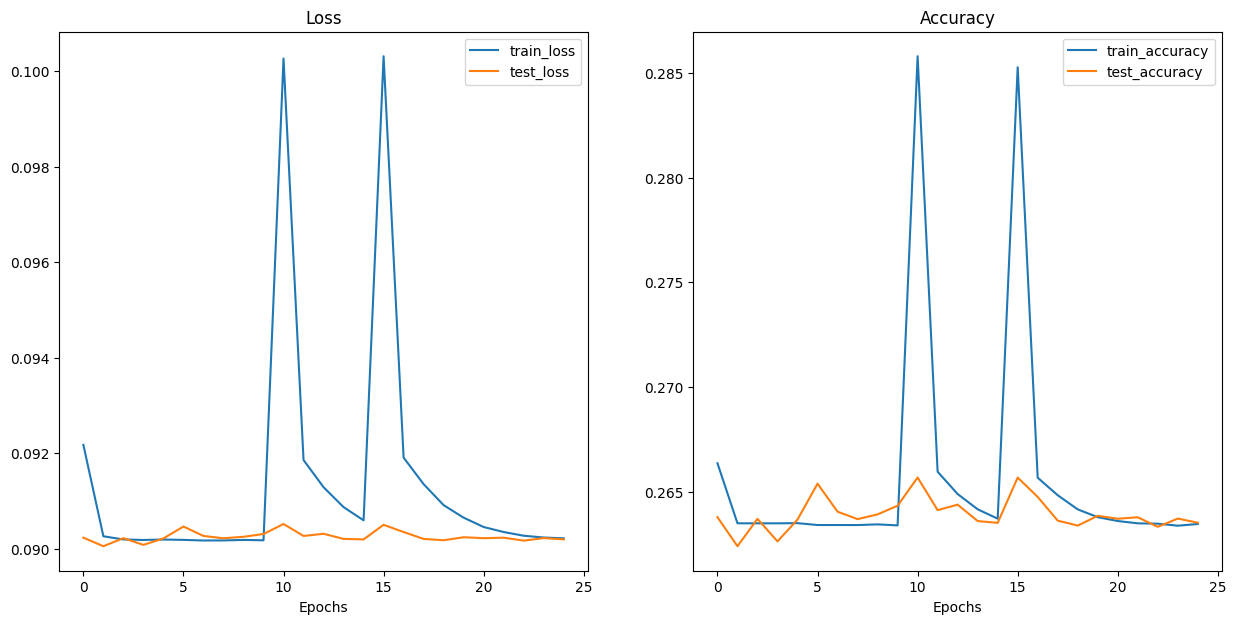

In [ ]:
plot_loss_curves(results)

#Recommendations

In [ ]:
# Example recommendation for a user
user_id = "AHZM3GVSTF4MCGO67QFLXCNIXSIQ"
user_index = user_map[user_id]

In [ ]:
def recommend(model, user_idx, item_indices, k=10):
    model.eval()
    user_tensor = torch.tensor([user_idx] * len(item_indices)).to("cuda")
    item_tensor = torch.tensor(item_indices).to("cuda")

    with torch.no_grad():
        predictions = model(user_tensor, item_tensor).squeeze()
    top_k_items = torch.topk(predictions, k=k).indices.cpu().numpy()
    return [list(item_map.keys())[i] for i in top_k_items]


item_indices = list(range(len(item_map)))
recommendations = recommend(ncf_model, user_index, item_indices)
print("Recommended items:", recommendations)


Recommended items: ['B08BBQ29N5', 'B099DRHW5V', 'B08BZ63GMJ', 'B00R8DXL44', 'B081TJ8YS3', 'B00YQ6X8EO', 'B097R46CSY', 'B09JS339BZ', 'B08P2DZB4X', 'B086QY6T7N']


[('B07F5HCQGH', 'https://m.media-amazon.com/images/I/51b1W67dgoL.jpg', 74140    2018 New Lazy Eye Shadow Applicator Silicone E...
Name: title, dtype: object), ('B01GUELMJC', 'https://m.media-amazon.com/images/I/41V5SUCK2uL.jpg', 53732    Aloe Vera Real Cleansing Foam
Name: title, dtype: object)]


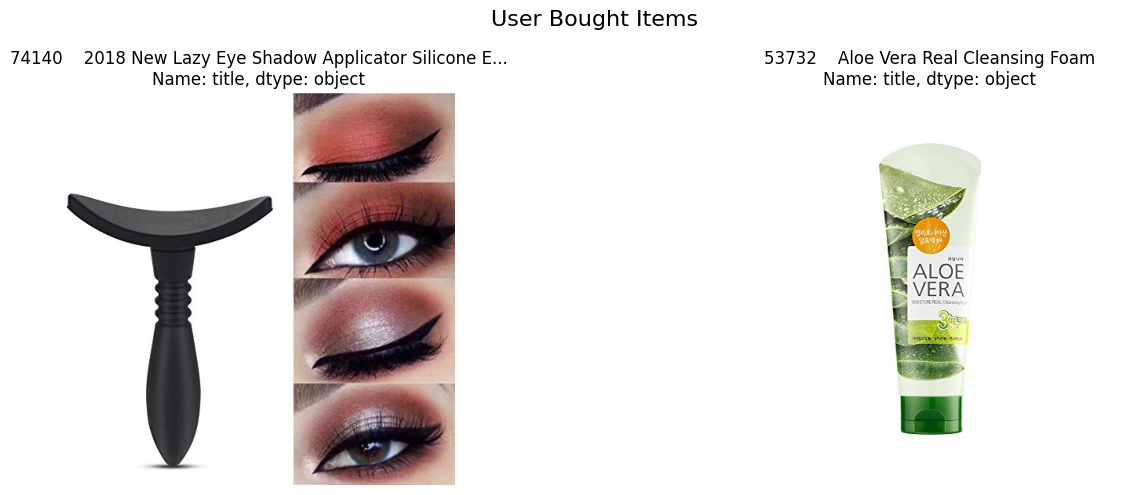

[('B08BBQ29N5', 'https://m.media-amazon.com/images/I/51Eh2NWQdXL.jpg', 2958    Niseyo new Faux Locs 24 Inch Crochet Hair 6 Pa...
Name: title, dtype: object), ('B099DRHW5V', 'https://m.media-amazon.com/images/I/31n5ARg+WZL.jpg', 84956    Disposable Facial Cotton Tissue, 100PCS Cotton...
Name: title, dtype: object), ('B08BZ63GMJ', 'https://m.media-amazon.com/images/I/41cMyE4DTmL.jpg', 58635    Yinhua Electric Nail Drill Kit Portable Profes...
Name: title, dtype: object), ('B00R8DXL44', 'https://m.media-amazon.com/images/I/31Fu9GxmLJL.jpg', 57662    China Glaze Nail Polish, Wanderlust 1381
Name: title, dtype: object), ('B081TJ8YS3', 'https://m.media-amazon.com/images/I/41Jq6qGaBBL.jpg', 32194    All Natural Vegan Dry Shampoo Powder - Eco Fri...
Name: title, dtype: object), ('B00YQ6X8EO', 'https://m.media-amazon.com/images/I/41VQKmI9uKL.jpg', 29624    Herbivore - Natural Sea Mist Texturizing Salt ...
Name: title, dtype: object), ('B097R46CSY', 'https://m.media-amazon.com/images/I/51S9bEeOc

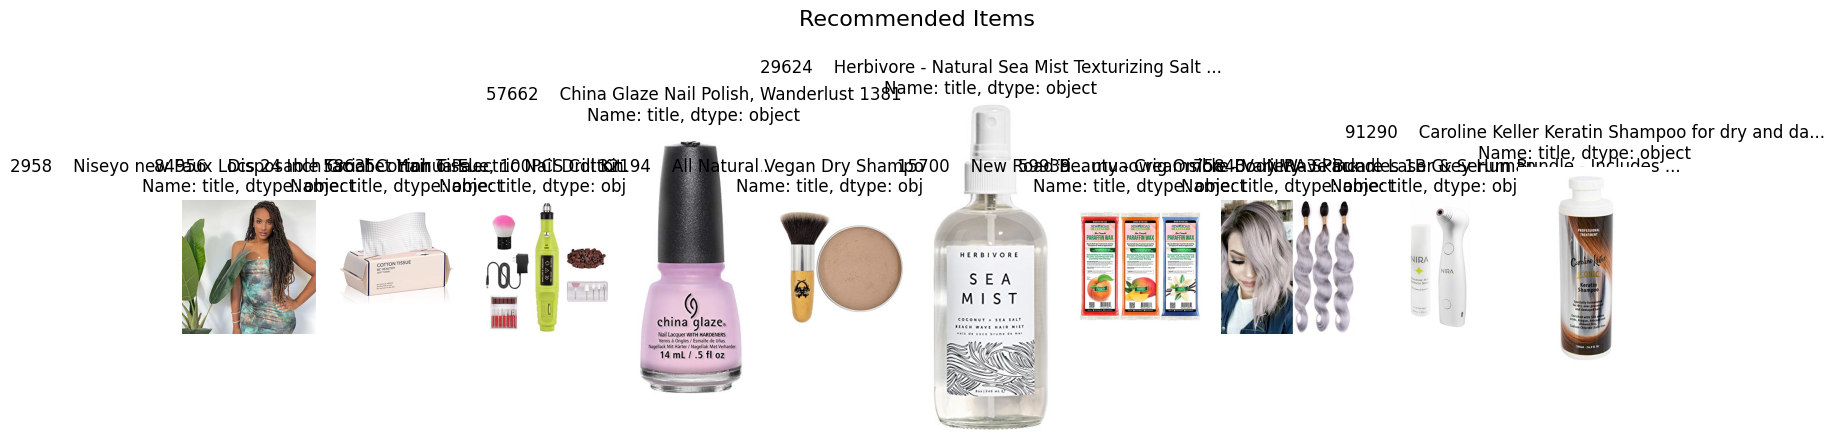

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

def fetch_item_images_from_df(asins, meta_df):

    items_with_images = []
    for asin in asins:
        row = meta_df[meta_df["parent_asin"] == asin]
        if not row.empty:
            images = row["images"].iloc[0]
            if images:
              items_with_images.append((asin, images["large"][0], row["title"]))
    return items_with_images

def display_items(title, items):
    print(items)

    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)

    for idx, (asin, image_urls, title) in enumerate(items):
        if image_urls:
            try:
                response = requests.get(image_urls)
                img = Image.open(BytesIO(response.content))

                plt.subplot(1, len(items), idx + 1)
                plt.imshow(img)
                plt.axis("off")
                plt.title(title)
            except Exception as e:
                print(f"Could not fetch image for ASIN {asin}: {e}")

    plt.tight_layout()
    plt.show()


# Fetch ASINs for bought items
#user_id = "user_1"
bought_asins = reviews_df[reviews_df["user_id"] == user_id]["asin"].tolist()

# Fetch images for recommended items
recommended_asins = recommend(ncf_model, user_index, list(range(len(item_map))))
bought_items = fetch_item_images_from_df(bought_asins, meta_df)
recommended_items = fetch_item_images_from_df(recommended_asins, meta_df)

# Display images
display_items("User Bought Items", bought_items)
display_items("Recommended Items", recommended_items)
